# compare the OpenPIV Python with PIVLab


In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

CPython 3.8.5
IPython 7.19.0

numpy 1.19.4
openpiv 0.23.2rc0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-56-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
from openpiv import windef
from openpiv.windef import Settings
from openpiv import tools, scaling, validation, filters, preprocess
from openpiv.pyprocess import extended_search_area_piv, get_field_shape, get_coordinates
from openpiv import smoothn
from openpiv.preprocess import mask_coordinates

import numpy as np
import os
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)


In [3]:
settings = Settings()

# 'Data related settings'
# Folder with the images to process
settings.filepath_images = '../data/'
# Folder for the outputs
settings.save_path = '../OpenPIV_results/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'
# settings.ROI = (200,400,600,850)



settings.deformation_method = 'symmetric' # or 'second image'


settings.iterations = 4  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(64, 32, 16, 6)
settings.overlap=(32, 16, 8, 3)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 1
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='linear'  # 'circular' or 'linear'
settings.normalized_correlation = True

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True


settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 10
settings.filter_kernel_size = 3  # kernel size for the localmean method

settings.replace_vectors = True

settings.MinMax_U_disp = (-5, 5)
settings.MinMax_V_disp = (-5, 5)

# The second filter is based on the global STD threshold
settings.std_threshold = 3  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median, it'll be 3 x 3


settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21

# New settings for version 0.23.2c
settings.image_mask = True

# Smoothing after the first pass
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter


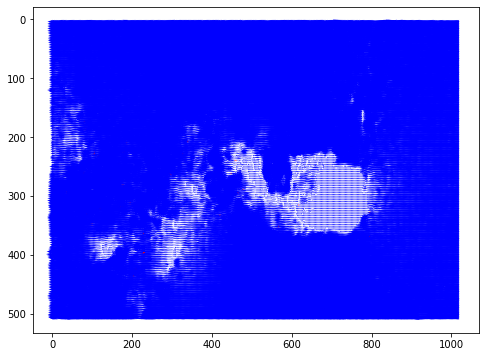

Image Pair 1


In [4]:
windef.piv(settings)

## Read and crop the images

In [5]:
file_a = settings.frame_pattern_a
file_b = settings.frame_pattern_b

# " read images into numpy arrays"
frame_a = tools.imread(os.path.join(settings.filepath_images, file_a))
frame_b = tools.imread(os.path.join(settings.filepath_images, file_b))

# " crop to ROI"
if settings.ROI == "full":
    pass
else:
    frame_a = frame_a[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]
    frame_b = frame_b[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]

## Show the images

In [6]:
plt.imshow(frame_a,cmap=plt.cm.gray)

## Image masking

In [7]:
# 'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS

if settings.dynamic_masking_method == "edge" or "intensity":
    frame_a, image_mask_a = preprocess.dynamic_masking(
        frame_a,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )
    frame_b, image_mask_b = preprocess.dynamic_masking(
        frame_b,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )

fig,ax = plt.subplots(1,2)
ax[0].imshow(frame_a)
ax[1].imshow(frame_b)

In [8]:
# let's combine the two masks if the body is slightly moving
image_mask = np.logical_and(image_mask_a, image_mask_b)
plt.imshow(image_mask)

## Exract coordinates of the mask as a list of coordinates of a polygon

In [9]:
mask_coords = mask_coordinates(image_mask)

## Run the first pass

We use typically the most robust approach: linear correlation (with zero padding)
    and normalized correlation function (0..1)

In [10]:
# In order to convert the image mask to the data mask in x,y 
# coordinates, we have to either run first pass or 
# use get_coordinates
# Since we do not know how to use the image_mask in the 
# first pass with the vectorized correlations, i.e. how to 
# save some computational time by skipping the interrogation
# windows within the image mask, we just run the first pass


# "first pass"
x, y, u, v, sig2noise_ratio = windef.first_pass(
    frame_a,
    frame_b,
    settings.windowsizes[0],
    settings.overlap[0],
    settings.iterations,
    correlation_method=settings.correlation_method,
    subpixel_method=settings.subpixel_method,
    do_sig2noise=settings.extract_sig2noise,
    sig2noise_method=settings.sig2noise_method,
    sig2noise_mask=settings.sig2noise_mask,
    normalized_correlation=settings.normalized_correlation
)

# store for the comparison of the following steps
u0 = u.copy()
v0 = v.copy()

def status_message(u):
    print(f"{np.isnan(u).sum()/u.size*100:.2f}% invalid vectors out of {u.size} vectors")
    
status_message(u)

0.43% invalid vectors out of 465 vectors


In [11]:
# Now we can convert the image mask to the data mask in x,y coordinates

from skimage.measure import points_in_poly

# mark those points on the grid of PIV inside the mask
xymask = points_in_poly(np.c_[y.flatten(),x.flatten()],mask_coords)

plt.imshow(~image_mask,cmap=plt.cm.gray)
plt.plot(x.flat[xymask],y.flat[xymask],'x')

In [12]:
# mask the velocity maps for the future use in validation
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = True

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

In [13]:
# we need to remove those values for the display
def quick_quiver():
    """ u,v expected to have a mask """
    plt.quiver(x,y,u,v,sig2noise_ratio, scale=50,color='b')
    plt.gca().invert_yaxis()
    plt.gca().set_aspect(1)
    plt.plot(x.flat[xymask],y.flat[xymask],'rx')
    plt.colorbar(orientation='horizontal')

In [14]:
quick_quiver()

In [15]:
# see the distribution of the signal to noise ratio
tmp = sig2noise_ratio.copy()
tmp[tmp>1000] = 0.0  # there are some extra high values 1e7 ...
plt.imshow(tmp)
plt.colorbar(orientation='horizontal')

In [16]:
plt.hist(tmp.flatten());

In [17]:
# let's consider 5% of signoise ratio problems. 
sig2noise_threshold = np.percentile(sig2noise_ratio[sig2noise_ratio>0],(5))
print(f"S2N threshold is estimated as {sig2noise_threshold:.3f}")

settings.sig2noise_threshold = sig2noise_threshold

S2N threshold is estimated as 1.785


In [18]:
u, v, mask_s2n = validation.sig2noise_val(
            u, v, sig2noise_ratio,
            threshold=settings.sig2noise_threshold
)

status_message(u)

5.59% invalid vectors out of 465 vectors


In [19]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_s2n],y[mask_s2n],u0[mask_s2n],v0[mask_s2n],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [20]:
# False everywhere, all passes
outliers_mask = np.full_like(x,False)

In [21]:
plt.hist(v.flatten())

(array([  2.,   3.,  40.,  35.,  94., 185.,  46.,  17.,  10.,   7.]),
 array([-1.94133529, -1.5730444 , -1.2047535 , -0.8364626 , -0.46817171,
        -0.09988081,  0.26841008,  0.63670098,  1.00499187,  1.37328277,
         1.74157366]),
 <BarContainer object of 10 artists>)

In [22]:
# 'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.

u, v, mask_g = validation.global_val(
    u, v, settings.MinMax_U_disp, settings.MinMax_V_disp
)

In [23]:
status_message(u)

5.59% invalid vectors out of 465 vectors


In [24]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_g],y[mask_g],u0[mask_g],v0[mask_g],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [25]:
## also global std should take masked array

In [26]:
# The second filter is based on the global STD threshold
settings.std_threshold = 3  # threshold of the std validation

u, v, mask_s = validation.global_std(
    u, v, std_threshold=settings.std_threshold
)


status_message(u)

5.59% invalid vectors out of 465 vectors


In [27]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_s],y[mask_s],u0[mask_s],v0[mask_s],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [28]:
## validation.local_median_val should also take masked array

In [29]:
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median

u, v, mask_m = validation.local_median_val(
    u,
    v,
    u_threshold=settings.median_threshold,
    v_threshold=settings.median_threshold,
    size=settings.median_size,
)


status_message(u)

5.59% invalid vectors out of 465 vectors


In [30]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_m],y[mask_m],u0[mask_m],v0[mask_m],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [31]:
# Combining masks
outliers_mask = mask_g + mask_m + mask_s + mask_s2n

In [32]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[outliers_mask],y[outliers_mask],u0[outliers_mask],v0[outliers_mask],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [33]:
status_message(u)

5.59% invalid vectors out of 465 vectors


In [34]:
# "filter to replace the values that where marked by the validation"
# if settings.iterations > 1:


u, v = filters.replace_outliers(
    u,
    v,
    method=settings.filter_method,
    max_iter=settings.max_filter_iteration,
    kernel_size=settings.filter_kernel_size,
)


In [35]:
# mask the velocity maps
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = 1

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

In [36]:
quick_quiver()

In [37]:
# Smoothing after the first pass
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter

u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
    u, s=settings.smoothn_p
)
v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
    v, s=settings.smoothn_p
)

# mask the velocity maps
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = 1

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

In [38]:
plt.figure(figsize=(20,12))
plt.quiver(x,y,u0,v0,color='r',scale=30,alpha=0.5)
plt.quiver(x,y,u,v,sig2noise_ratio,scale=30)
plt.plot(x.flat[xymask],y.flat[xymask],'ro')
plt.gca().invert_yaxis()
plt.colorbar(orientation='horizontal')
plt.gca().set_aspect(1.)

## Multi-pass loop with window deformation, validation and smoothing

**Note**: no smoothing on the last step

In [39]:
for i in range(1, settings.iterations): ## all other passes
    x, y, u, v, sig2noise_ratio = windef.multipass_img_deform(
        frame_a,
        frame_b,
        settings.windowsizes[i],
        settings.overlap[i],
        settings.iterations,
        i,
        x,
        y,
        u,
        v,
        correlation_method=settings.correlation_method,
        subpixel_method=settings.subpixel_method,
        deformation_method=settings.deformation_method,
        do_sig2noise=settings.extract_sig2noise,
        sig2noise_method=settings.sig2noise_method,
        sig2noise_mask=settings.sig2noise_mask,
        interpolation_order=settings.interpolation_order,
        normalized_correlation=settings.normalized_correlation,
        mask_coords=mask_coords,
    )
    
    mask = u.mask
    
    # Now we can first validate, filter out, interpolate
    # and then smooth the data for this pass:
    
    outliers_mask = np.full_like(x,False)
    
    if (
        settings.extract_sig2noise is True
        and i == settings.iterations
        and settings.iterations != 1
        and settings.do_sig2noise_validation is True
    ):
        u, v, mask_s2n = validation.sig2noise_val(
            u, v, sig2noise_ratio, threshold=settings.sig2noise_threshold
        )
        outliers_mask += mask_s2n

    
    # validation using gloabl limits and local median
    u, v, mask_g = validation.global_val(u, v, settings.MinMax_U_disp, 
                                         settings.MinMax_V_disp)
    u, v, mask_s = validation.global_std(u, v, 
                                         std_threshold=settings.std_threshold)
    u, v, mask_m = validation.local_median_val(u, v,
                        u_threshold=settings.median_threshold,
                        v_threshold=settings.median_threshold,
                        size=settings.median_size,
    )

    # adding masks to add the effect of alle the validations
    outliers_mask += (mask_g + mask_s + mask_m)

    # filter to replace the values that where marked by the validation
    # not applied at the last step 

    if settings.replace_vectors is True:
        u, v = filters.replace_outliers(
            u,
            v,
            method=settings.filter_method,
            max_iter=settings.max_filter_iteration,
            kernel_size=settings.filter_kernel_size,
        )
        
    if (i != settings.iterations) and (settings.smoothn is True):
        u, _, _, _ = smoothn.smoothn(
                     u, s=settings.smoothn_p )
        v, _, _, _ = smoothn.smoothn(
                     v, s=settings.smoothn_p)

    # reapply image mask just to be sure
    if len(mask_coords) > 1:
        u = np.ma.masked_array(u, mask=mask)
        v = np.ma.masked_array(v, mask=mask)

        
# TODO: remove
plt.figure()
plt.quiver(x, y, u, v,color='r')
# plt.quiver(x_int, y_int, u_pre, v_pre,color='b')
plt.gca().invert_yaxis()
plt.gca().set_aspect(1)
plt.title('end of the loop')

Text(0.5, 1.0, 'end of the loop')

## Save the outcome

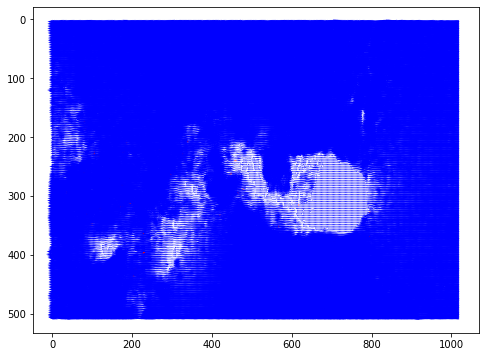

<Figure size 576x432 with 0 Axes>

Image Pair 1


In [40]:
save_path = '.'
counter = 0

# "pixel/frame->pixel/sec"
u = u / settings.dt
v = v / settings.dt

# "scales the results pixel-> meter"
x, y, u, v = scaling.uniform(x, y, u, v,
                             scaling_factor=settings.scaling_factor)
# "save to a file"
tools.save(
    x,
    y,
    u,
    v,
    sig2noise_ratio,
    outliers_mask,
    os.path.join(save_path, "field_A%03d.txt" % counter),
    delimiter="\t",
)

# "some other stuff that one might want to use"
settings.show_plot = True
settings.save_plot = True

if settings.show_plot is True or settings.save_plot is True:
    plt.close("all")
    plt.ioff()
    filename = os.path.join(save_path, "Image_A%03d.png" % counter)
    tools.display_vector_field(
        os.path.join(save_path, "field_A%03d.txt" % counter),
        scale=settings.scale_plot,
    )
    if settings.save_plot is True:
        plt.savefig(filename)
    if settings.show_plot is True:
        plt.show()

print("Image Pair " + str(counter+1))

In [41]:
attrs = vars(settings)
print(', '.join("%s: %s \n" % item for item in attrs.items()))

filepath_images: ../data/ 
, save_path: ../OpenPIV_results/ 
, save_folder_suffix: Test_1 
, frame_pattern_a: karman_16Hz_000_A.jpg 
, frame_pattern_b: karman_16Hz_000_B.jpg 
, ROI: full 
, deformation_method: symmetric 
, iterations: 4 
, windowsizes: (64, 32, 16, 6) 
, overlap: (32, 16, 8, 3) 
, subpixel_method: gaussian 
, interpolation_order: 1 
, scaling_factor: 1 
, dt: 1 
, extract_sig2noise: True 
, sig2noise_method: peak2peak 
, sig2noise_mask: 2 
, save_plot: True 
, show_plot: True 
, scale_plot: 200 
, correlation_method: linear 
, normalized_correlation: True 
, validation_first_pass: True 
, filter_method: localmean 
, max_filter_iteration: 10 
, filter_kernel_size: 3 
, replace_vectors: True 
, MinMax_U_disp: (-5, 5) 
, MinMax_V_disp: (-5, 5) 
, std_threshold: 3 
, median_threshold: 3 
, median_size: 1 
, dynamic_masking_method: intensity 
, dynamic_masking_threshold: 0.1 
, dynamic_masking_filter_size: 21 
, image_mask: True 
, smoothn: True 
, smoothn_p: 0.5 
, sig2noi